# Riiid! Answer Correctness Prediction. Data Analysis and visualization and Modeling

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py


#Number of records

In [2]:
!wc -l ../input/riiid-test-answer-prediction/train.csv

101230333 ../input/riiid-test-answer-prediction/train.csv


**Train.csv**
* row_id: (int64) ID code for the row.

* timestamp: (int64) the time between this user interaction and the first event from that user.

* user_id: (int32) ID code for the user.

* content_id: (int16) ID code for the user interaction

* content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.

* task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id. Monotonically increasing for each user.

* user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.

* answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.

* prior_question_elapsed_time: (float32) How long it took a user to answer their previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Note that the time is the total time a user took to solve all the questions in the previous bundle.

* prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

In [7]:
import pandas as pd

# Загрузка первых 1 млн строк train.csv
train_path = '../input/riiid-test-answer-prediction/train.csv'
train_df = pd.read_csv(train_path, nrows=1_000_000)

# Проверка загруженных данных
print(f"Shape of the loaded data: {train_df.shape}")
print(train_df.head())

Shape of the loaded data: (1000000, 10)
   row_id  timestamp  user_id  content_id  content_type_id  task_container_id  \
0       0          0      115        5692                0                  1   
1       1      56943      115        5716                0                  2   
2       2     118363      115         128                0                  0   
3       3     131167      115        7860                0                  3   
4       4     137965      115        7922                0                  4   

   user_answer  answered_correctly  prior_question_elapsed_time  \
0            3                   1                          NaN   
1            2                   1                      37000.0   
2            0                   1                      55000.0   
3            0                   1                      19000.0   
4            1                   1                      11000.0   

  prior_question_had_explanation  
0                            NaN  


In [9]:
# Изучение структуры данных
print("Столбцы и типы данных:")
print(train_df.info())

print("\nКоличество пропусков в данных:")
print(train_df.isnull().sum())

Столбцы и типы данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   row_id                          1000000 non-null  int64  
 1   timestamp                       1000000 non-null  int64  
 2   user_id                         1000000 non-null  int64  
 3   content_id                      1000000 non-null  int64  
 4   content_type_id                 1000000 non-null  int64  
 5   task_container_id               1000000 non-null  int64  
 6   user_answer                     1000000 non-null  int64  
 7   answered_correctly              1000000 non-null  int64  
 8   prior_question_elapsed_time     976277 non-null   float64
 9   prior_question_had_explanation  996184 non-null   object 
dtypes: float64(1), int64(8), object(1)
memory usage: 76.3+ MB
None

Количество пропусков в данных:
row_id   

Распределение 'answered_correctly':
 1    0.637411
 0    0.342682
-1    0.019907
Name: answered_correctly, dtype: float64

Связь между 'prior_question_had_explanation' и 'answered_correctly':
prior_question_had_explanation
False    0.209978
True     0.665913
Name: answered_correctly, dtype: float64


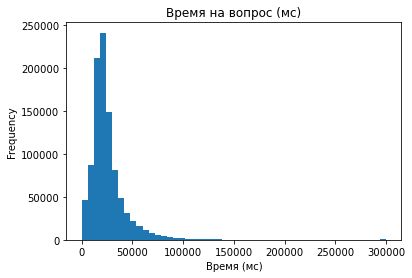

In [11]:
#Анализ столбцов
#Посмотрим основные характеристики:
#answered_correctly: распределение правильных ответов (это наша целевая переменная).
#prior_question_had_explanation: связь с результатами.
#prior_question_elapsed_time: распределение времени.


import matplotlib.pyplot as plt

# Распределение целевой переменной
print("Распределение 'answered_correctly':")
print(train_df['answered_correctly'].value_counts(normalize=True))

# Связь между наличием объяснений и правильными ответами
print("\nСвязь между 'prior_question_had_explanation' и 'answered_correctly':")
print(train_df.groupby('prior_question_had_explanation')['answered_correctly'].mean())

# Распределение времени на предыдущий вопрос
train_df['prior_question_elapsed_time'].plot(kind='hist', bins=50, title='Время на вопрос (мс)')
plt.xlabel('Время (мс)')
plt.show()

In [18]:
#Выделение признаков

#Средняя точность пользователя (user_accuracy).
#Средняя сложность вопроса (question_difficulty).

# Средняя точность пользователя
user_accuracy = train_df.groupby('user_id')['answered_correctly'].mean()
train_df['user_accuracy'] = train_df['user_id'].map(user_accuracy)

# Средняя сложность вопроса
question_difficulty = train_df.groupby('content_id')['answered_correctly'].mean()
train_df['question_difficulty'] = train_df['content_id'].map(question_difficulty)

print(train_df[['user_accuracy', 'question_difficulty']].head())


   user_accuracy  question_difficulty
0       0.695652             0.721068
1       0.695652             0.768595
2       0.695652             0.961326
3       0.695652             0.926108
4       0.695652             0.959064


In [19]:
# Выделение признаков

# 1. Средняя точность пользователя (user_accuracy).
# Средняя сложность вопроса (question_difficulty).
# Средняя точность пользователя
user_accuracy = train_df.groupby('user_id')['answered_correctly'].mean()
train_df['user_accuracy'] = train_df['user_id'].map(user_accuracy)

# Средняя сложность вопроса
question_difficulty = train_df.groupby('content_id')['answered_correctly'].mean()
train_df['question_difficulty'] = train_df['content_id'].map(question_difficulty)

# 2. Количество вопросов, отвеченных пользователем
user_question_count = train_df.groupby('user_id')['row_id'].count()
train_df['user_question_count'] = train_df['user_id'].map(user_question_count)

# 3. Среднее время ответа пользователя
user_avg_time = train_df.groupby('user_id')['prior_question_elapsed_time'].mean()
train_df['user_avg_time'] = train_df['user_id'].map(user_avg_time)

# 4. Среднее время ответа на вопрос
question_avg_time = train_df.groupby('content_id')['prior_question_elapsed_time'].mean()
train_df['question_avg_time'] = train_df['content_id'].map(question_avg_time)

# 5. Количество попыток ответить на вопрос
question_attempt_count = train_df.groupby('content_id')['row_id'].count()
train_df['question_attempt_count'] = train_df['content_id'].map(question_attempt_count)

# 6. Взаимодействие точности пользователя и сложности вопроса
train_df['user_difficulty_interaction'] = train_df['user_accuracy'] * train_df['question_difficulty']

# 7. Взаимодействие времени пользователя и сложности вопроса
train_df['time_difficulty_interaction'] = train_df['user_avg_time'] * train_df['question_difficulty']

# 8. Время с первого ответа пользователя
train_df['timestamp'] = train_df['timestamp'] / 1000  # переводим в секунды
user_first_timestamp = train_df.groupby('user_id')['timestamp'].transform('min')
train_df['time_since_start'] = train_df['timestamp'] - user_first_timestamp

# 9. Скользящее среднее точности пользователя (rolling average accuracy)
train_df['rolling_user_accuracy'] = train_df.groupby('user_id')['answered_correctly'].transform(
    lambda x: x.rolling(window=5, min_periods=1).mean()
)

# 10. Кумулятивная точность пользователя
train_df['cumulative_accuracy'] = train_df.groupby('user_id')['answered_correctly'].expanding().mean().reset_index(level=0, drop=True)

# Проверяем, что все признаки созданы
print("Новые признаки:")
print(train_df[['user_accuracy', 'question_difficulty', 'user_question_count', 
                'user_avg_time', 'question_avg_time', 'question_attempt_count', 
                'user_difficulty_interaction', 'time_difficulty_interaction',
                'time_since_start', 'rolling_user_accuracy', 'cumulative_accuracy']].head())

Новые признаки:
   user_accuracy  question_difficulty  user_question_count  user_avg_time  \
0       0.695652             0.721068                   46   19933.311111   
1       0.695652             0.768595                   46   19933.311111   
2       0.695652             0.961326                   46   19933.311111   
3       0.695652             0.926108                   46   19933.311111   
4       0.695652             0.959064                   46   19933.311111   

   question_avg_time  question_attempt_count  user_difficulty_interaction  \
0       25673.450980                     337                     0.501613   
1       21529.198347                     242                     0.534675   
2       24178.571429                     181                     0.668748   
3       19392.857143                     203                     0.644249   
4       20824.561404                     171                     0.667175   

   time_difficulty_interaction  time_since_start  rolling_

In [ ]:
#Признаки
#Количество вопросов, отвеченных пользователем (user_question_count) — позволяет понять, насколько активно пользователь участвует в тестах.
#Среднее время ответа пользователя (user_avg_time) — помогает понять, насколько быстро или медленно пользователь отвечает на вопросы.
#Среднее время ответа на вопрос (question_avg_time) — показывает, сколько времени в среднем пользователи тратят на конкретные вопросы.
#Количество попыток ответа на вопрос (question_attempt_count) — может быть полезно для выявления сложных вопросов.
#Интерактивные признаки: взаимодействие точности пользователя и сложности вопроса, а также времени пользователя и сложности вопроса.
#Время с первого ответа пользователя (time_since_start) — помогает оценить, сколько времени прошло с момента начала обучения пользователя.
#Скользящее среднее точности пользователя (rolling_user_accuracy) — улучшает стабильность модели.
#Кумулятивная точность пользователя (cumulative_accuracy) — помогает отслеживать, как точность пользователя меняется с течением времени.


In [20]:
# Обработка пропусков
# Заполняем пропуски в числовых колонках средними значениями
train_df.fillna({
    'prior_question_elapsed_time': train_df['prior_question_elapsed_time'].mean(),
    'prior_question_had_explanation': 0,
    'user_accuracy': train_df['user_accuracy'].mean(),
    'question_difficulty': train_df['question_difficulty'].mean(),
    'user_question_count': 0,
    'user_avg_time': train_df['user_avg_time'].mean(),
    'question_avg_time': train_df['question_avg_time'].mean(),
    'question_attempt_count': 0
}, inplace=True)

print("Проверка пропусков после обработки:")
print(train_df.isnull().sum())

Проверка пропусков после обработки:
row_id                            0
timestamp                         0
user_id                           0
content_id                        0
content_type_id                   0
task_container_id                 0
user_answer                       0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
user_accuracy                     0
question_difficulty               0
user_question_count               0
user_avg_time                     0
question_avg_time                 0
time_since_start                  0
rolling_user_accuracy             0
user_difficulty_interaction       0
time_difficulty_interaction       2
question_attempt_count            0
cumulative_accuracy               0
session_id                        0
dtype: int64


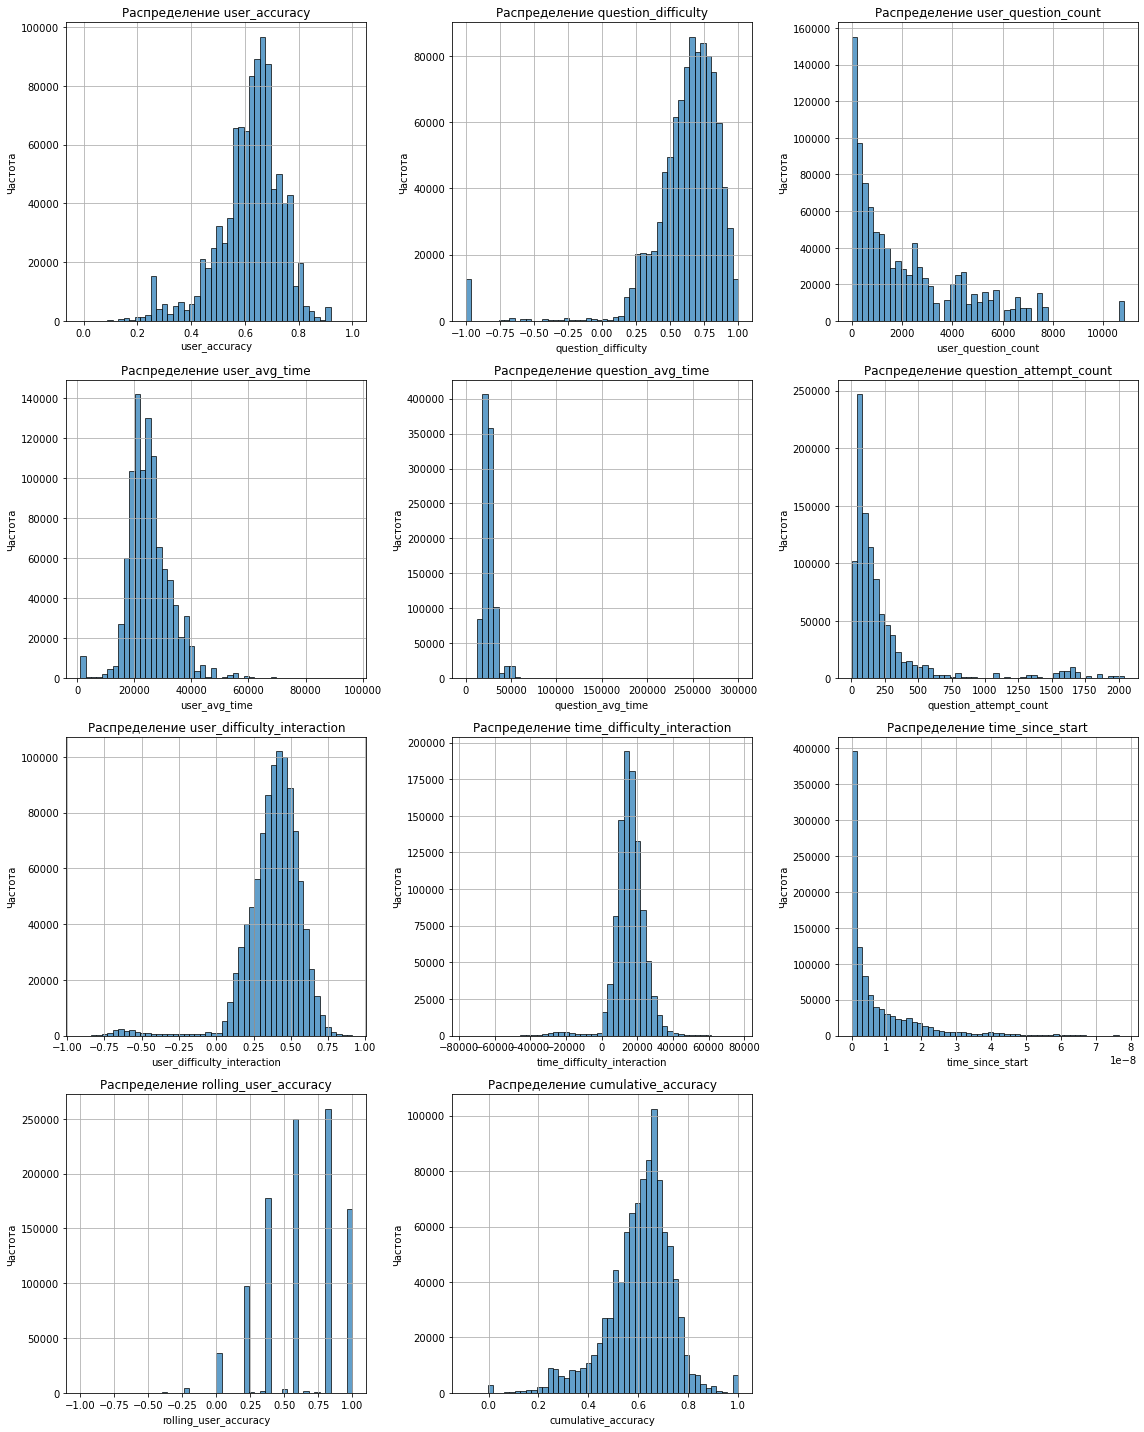

In [26]:
import matplotlib.pyplot as plt

# Список признаков для визуализации
features_to_plot = [
    'user_accuracy', 'question_difficulty', 'user_question_count',
    'user_avg_time', 'question_avg_time', 'question_attempt_count',
    'user_difficulty_interaction', 'time_difficulty_interaction',
    'time_since_start', 'rolling_user_accuracy', 'cumulative_accuracy'
]

# Создаем графики распределения для каждого признака
plt.figure(figsize=(16, 20))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(4, 3, i)
    train_df[feature].dropna().hist(bins=50, edgecolor='k', alpha=0.7)
    plt.title(f'Распределение {feature}', fontsize=12)
    plt.xlabel(feature)
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()